In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv('../data/raw/electricity_marketing_dataset.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
df = df.sort_index()

print("Starting feature engineering...")
data = df.copy()

data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month

data = pd.get_dummies(data, columns=['consumer_type'], drop_first=False)

if 'demand_category' in data.columns:
    data = data.drop(columns=['demand_category'])

print("DataFrame after feature engineering:")
print(data.head())
print("\nNew DataFrame info:")
data.info()

Starting feature engineering...
DataFrame after feature engineering:
                     temperature  humidity  is_weekend  is_holiday  \
timestamp                                                            
2024-01-01 00:00:00     0.526922  0.265203           0           1   
2024-01-01 01:00:00     0.437412  0.539677           0           1   
2024-01-01 02:00:00     0.548204  0.632031           0           1   
2024-01-01 03:00:00     0.671595  0.254353           0           1   
2024-01-01 04:00:00     0.423895  0.135163           0           1   

                     price_signal  historical_avg_demand  voltage_level  \
timestamp                                                                 
2024-01-01 00:00:00      0.469818               0.080994       0.538437   
2024-01-01 01:00:00      0.431329               0.080842       0.412133   
2024-01-01 02:00:00      0.712748               0.434790       0.784449   
2024-01-01 03:00:00      0.708677               0.641761       0.

In [3]:
import numpy as np

print("Loading pre-processed and pre-sequenced data...")

X_train_seq = np.load('../data/processed/X_train.npy')
y_train_seq = np.load('../data/processed/y_train.npy')
X_val_seq = np.load('../data/processed/X_val.npy')
y_val_seq = np.load('../data/processed/y_val.npy')
X_test_seq = np.load('../data/processed/X_test.npy')
y_test_seq = np.load('../data/processed/y_test.npy')

print("Data loaded successfully.")
print("\n--- Final Data Shapes for Model ---")
print(f"X_train_seq shape: {X_train_seq.shape}")
print(f"y_train_seq shape: {y_train_seq.shape}")
print(f"X_val_seq shape: {X_val_seq.shape}")
print(f"y_val_seq shape: {y_val_seq.shape}")
print(f"X_test_seq shape: {X_test_seq.shape}")
print(f"y_test_seq shape: {y_test_seq.shape}")

n_timesteps = X_train_seq.shape[1]
n_features = X_train_seq.shape[2]

print(f"\nModel input shape will be: ({n_timesteps}, {n_features})")

Loading pre-processed and pre-sequenced data...
Data loaded successfully.

--- Final Data Shapes for Model ---
X_train_seq shape: (479, 24, 13)
y_train_seq shape: (479, 1)
X_val_seq shape: (85, 24, 13)
y_val_seq shape: (85, 1)
X_test_seq shape: (84, 24, 13)
y_test_seq shape: (84, 1)

Model input shape will be: (24, 13)


In [ ]:
print("Building the CNN-BiLSTM model...")

input_shape = (n_timesteps, n_features) 

model = Sequential()

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(25)))
model.add(Dropout(0.2))

model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='linear'))

model.summary()

Building the CNN-BiLSTM model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 22, 64)         │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 10, 100)        │        33,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 50)             │        25,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,437 (267.33 KB)

 Trainable params: 68,437 (267.33 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

print("Compiling model...")
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error'
)


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("Training model...")
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stopping],
    verbose=1
)

print("Model training complete.")

Compiling model...
Training model...
Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0616 - val_loss: 0.0090
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0165 - val_loss: 0.0208
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0116 - val_loss: 0.0104
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069 - val_loss: 0.0058
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0056 - val_loss: 0.0047
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045 - val_loss: 0.0033
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0043 - val_loss: 0.0047
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 12/100
15/15 ━

Plotting model training history...


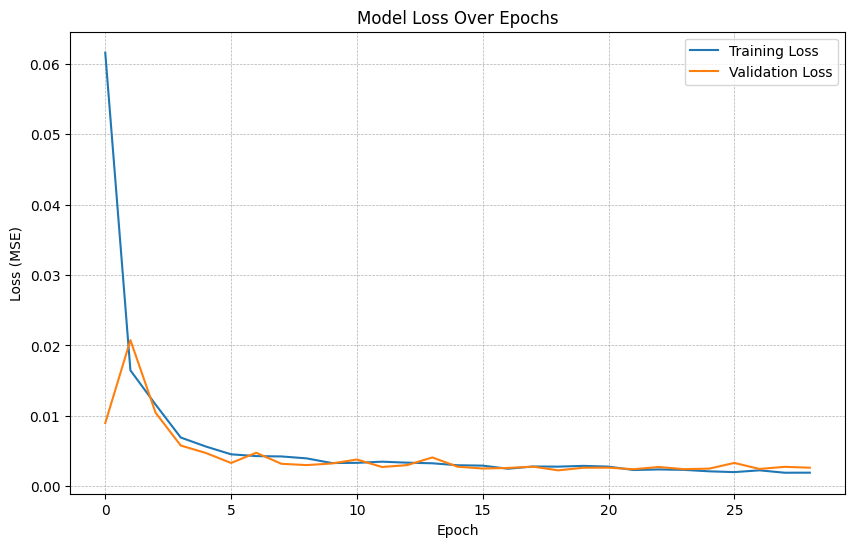

In [6]:
print("Plotting model training history...")

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

Successfully re-created and fit 'scaler_y' object.
Making predictions on the test set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Predictions and actuals have been inverse-scaled.

--- CNN-BiLSTM Model Evaluation (Test Set) ---
Root Mean Squared Error (RMSE): 0.0894
Mean Absolute Error (MAE):      0.0735
Mean Absolute Percentage Error (MAPE): 16.62%

Plotting actual vs. predicted values...


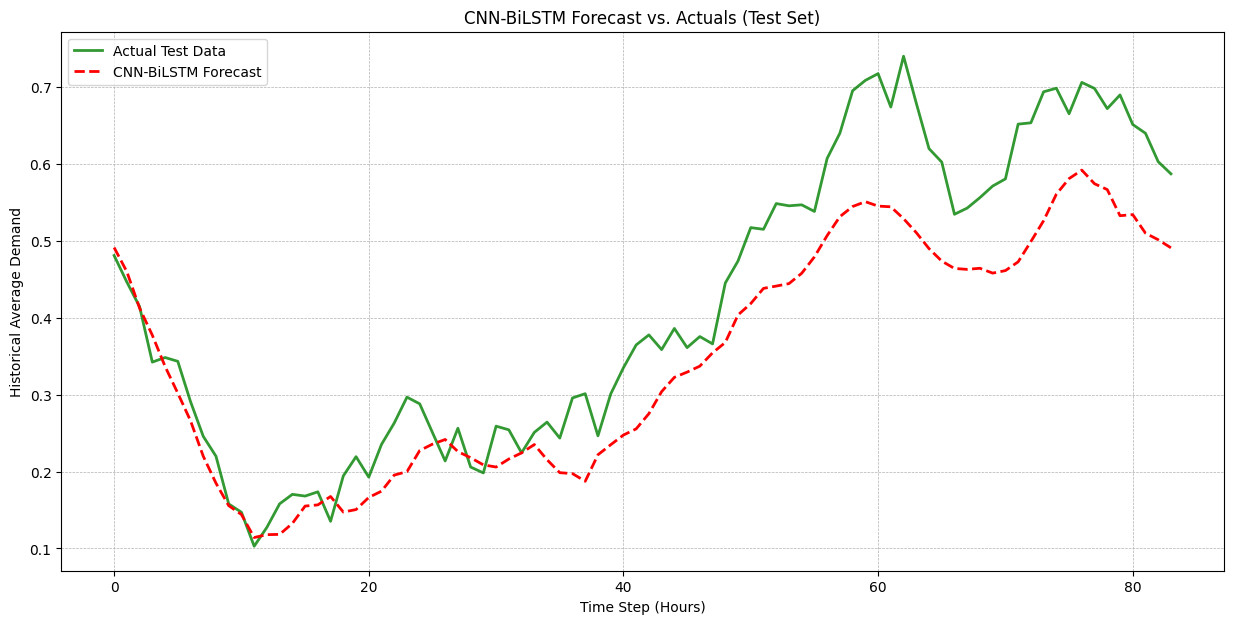

In [ ]:
# -print("Re-creating the y-scaler...")

original_data_filename = '../data/raw/electricity_marketing_dataset.csv' 

original_df = pd.read_csv(original_data_filename)

original_df['timestamp'] = pd.to_datetime(original_df['timestamp'])
original_df = original_df.set_index('timestamp').sort_index()

y_unscaled = original_df['historical_avg_demand']

total_size = len(y_unscaled)
train_size = int(total_size * 0.70)

y_train_unscaled = y_unscaled.iloc[:train_size]

scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_y.fit(y_train_unscaled.values.reshape(-1, 1))

print("Successfully re-created and fit 'scaler_y' object.")

print("Making predictions on the test set...")
y_pred_scaled = model.predict(X_test_seq)

y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_seq)

print("Predictions and actuals have been inverse-scaled.")

def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    if np.sum(non_zero_mask) == 0:
        return np.inf
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

test_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
test_mae = mean_absolute_error(y_true, y_pred)
test_mape = calculate_mape(y_true, y_pred)

print("\n--- CNN-BiLSTM Model Evaluation (Test Set) ---")
print(f"Root Mean Squared Error (RMSE): {test_rmse:.4f}")
print(f"Mean Absolute Error (MAE):      {test_mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {test_mape:.2f}%")

print("\nPlotting actual vs. predicted values...")
plt.figure(figsize=(15, 7))
plt.plot(y_true, label='Actual Test Data', color='green', linewidth=2, alpha=0.8)
plt.plot(y_pred, label='CNN-BiLSTM Forecast', color='red', linestyle='--', linewidth=2)
plt.title('CNN-BiLSTM Forecast vs. Actuals (Test Set)')
plt.xlabel('Time Step (Hours)')
plt.ylabel('Historical Average Demand')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()